# 🚀 Fase 13: Modelo Maestro de Producción e Inteligencia Explicable

### 🧠 Visión del Proyecto
Este notebook representa la culminación técnica del sistema: la **traducción de un algoritmo complejo a una herramienta de triaje médico**. En esta fase, eliminamos el escalado estadístico para operar con la **escala biológica real** del paciente.

### 🎯 Pilares de Producción:
1. **Fidelidad Biológica:** Trabajamos con años y mg/dL reales, permitiendo que cada decisión del modelo sea interpretable por un profesional de la salud.
2. **Ingeniería de Cuartiles:** Discretizamos variables continuas para capturar el riesgo no lineal, identificando los "umbrales críticos" donde la probabilidad de infarto se dispara.
3. **Calibración de Triaje:** Optimizamos el umbral para garantizar un **80% de Recall**, asegurando que la App actúe como una red de seguridad efectiva.
4. **Explicabilidad (SHAP):** Abrimos la "caja negra" del modelo para visualizar cuánto aporta cada factor de riesgo a la alerta final.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# 1. Carga de datos reales
df = pd.read_csv('dataset/healthcare-dataset-stroke-transformed.csv')

# 2. Ingeniería de Características: Cuartiles con Valores Reales
def crear_cuartiles_produccion(df, columna):
    etiquetas = ['Q1_Bajo', 'Q2_Medio', 'Q3_Alto', 'Q4_Critico']
    # retbins=True es vital para guardar los números exactos para la App
    serie_cat, bins = pd.qcut(df[columna], 4, labels=etiquetas, retbins=True)
    return serie_cat, bins

df['age_cat'], bins_age = crear_cuartiles_produccion(df, 'age')
df['glucose_cat'], bins_glucose = crear_cuartiles_produccion(df, 'avg_glucose_level')
df['bmi_cat'], bins_bmi = crear_cuartiles_produccion(df, 'bmi')

# Guardamos los límites originales en un diccionario
config_umbrales = {
    "age_bins": bins_age.tolist(),
    "glucose_bins": bins_glucose.tolist(),
    "bmi_bins": bins_bmi.tolist()
}

# Preparamos el dataset eliminando las numéricas y convirtiendo a Dummies
df_cat = df.drop(['age', 'avg_glucose_level', 'bmi'], axis=1)
df_final = pd.get_dummies(df_cat)

print(f"✅ Umbrales de Edad detectados: {bins_age}")
print(f"✅ Umbrales de Glucosa detectados: {bins_glucose}")

✅ Umbrales de Edad detectados: [8.0e-02 2.5e+01 4.5e+01 6.1e+01 8.2e+01]
✅ Umbrales de Glucosa detectados: [ 55.12  77.24  91.88 114.09 271.74]


### 🛠 Nota Técnica: Invarianza de Escala en Algoritmos de Boosting
En este punto, es crucial observar que **XGBoost**, al ser un ensamble de árboles de decisión, no basa su aprendizaje en distancias euclidianas (como KNN o SVM), sino en **particiones lógicas (splits)**. 

Esto nos permite eliminar el paso de escalamiento. El modelo encontrará que el "corte de riesgo" es el mismo si usamos la edad de `0.85` (escalada) o `72` (real). Esta decisión de ingeniería reduce la carga computacional de la App final y elimina fuentes potenciales de error en la transformación de datos del usuario.

In [12]:
# 3. Definición del Modelo Líder (Hiperparámetros Optimizados)
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']

model_master = XGBClassifier(
    n_estimators=125,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.9,
    colsample_bytree=1.0,
    scale_pos_weight=19.4, 
    random_state=42,
    eval_metric='logloss'
)

model_master.fit(X, y)
y_probs = model_master.predict_proba(X)[:, 1]

print("🚀 Modelo Maestro entrenado con éxito sobre variables de rango real.")

🚀 Modelo Maestro entrenado con éxito sobre variables de rango real.


### 📈 Calibración del Punto de Corte Clínico
El estándar estadístico sugiere un umbral de `0.5`, pero en medicina preventiva, este valor suele ser inadecuado. A continuación, visualizaremos la curva **Precision-Recall** para identificar el umbral exacto que nos permita "atrapar" al 80% de los pacientes en riesgo, analizando el compromiso (trade-off) que esto implica para la precisión del sistema.

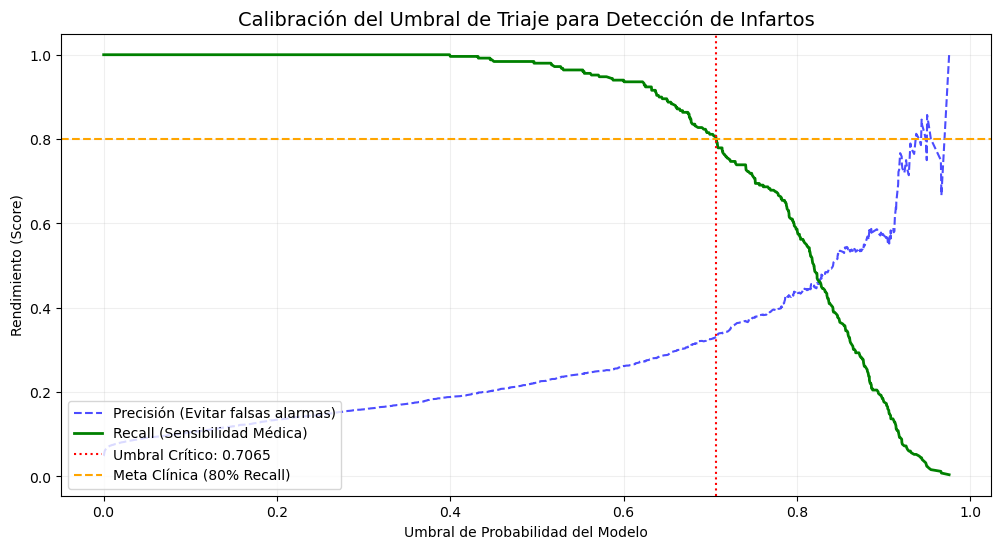

In [13]:
# 4. Cálculo de curvas de rendimiento
precisions, recalls, thresholds = precision_recall_curve(y, y_probs)

# Buscamos el umbral para Recall >= 80%
idx_80 = np.where(recalls >= 0.80)[0][-1]
umbral_seleccionado = thresholds[idx_80]

# 5. VISUALIZACIÓN DE OPTIMIZACIÓN (Brillante para la presentación)
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precisión (Evitar falsas alarmas)', alpha=0.7)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall (Sensibilidad Médica)', linewidth=2)
plt.axvline(x=umbral_seleccionado, color='red', linestyle=':', label=f'Umbral Crítico: {umbral_seleccionado:.4f}')
plt.axhline(y=0.80, color='orange', linestyle='--', label='Meta Clínica (80% Recall)')

plt.title('Calibración del Umbral de Triaje para Detección de Infartos', fontsize=14)
plt.xlabel('Umbral de Probabilidad del Modelo')
plt.ylabel('Rendimiento (Score)')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.2)
plt.show()

--- REPORTE DE CALIDAD (Umbral: 0.7065) ---
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      4860
           1       0.33      0.80      0.47       249

    accuracy                           0.91      5109
   macro avg       0.66      0.86      0.71      5109
weighted avg       0.96      0.91      0.93      5109



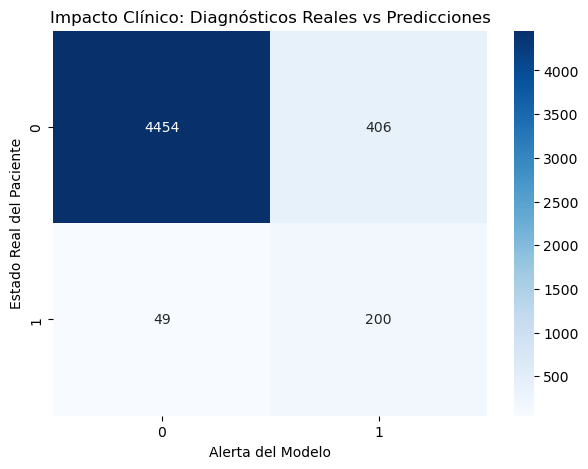

In [14]:
# 6. Evaluación Final
y_pred = (y_probs >= umbral_seleccionado).astype(int)

print(f"--- REPORTE DE CALIDAD (Umbral: {umbral_seleccionado:.4f}) ---")
print(classification_report(y, y_pred))

# 7. Matriz de Confusión
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Impacto Clínico: Diagnósticos Reales vs Predicciones')
plt.ylabel('Estado Real del Paciente')
plt.xlabel('Alerta del Modelo')
plt.show()

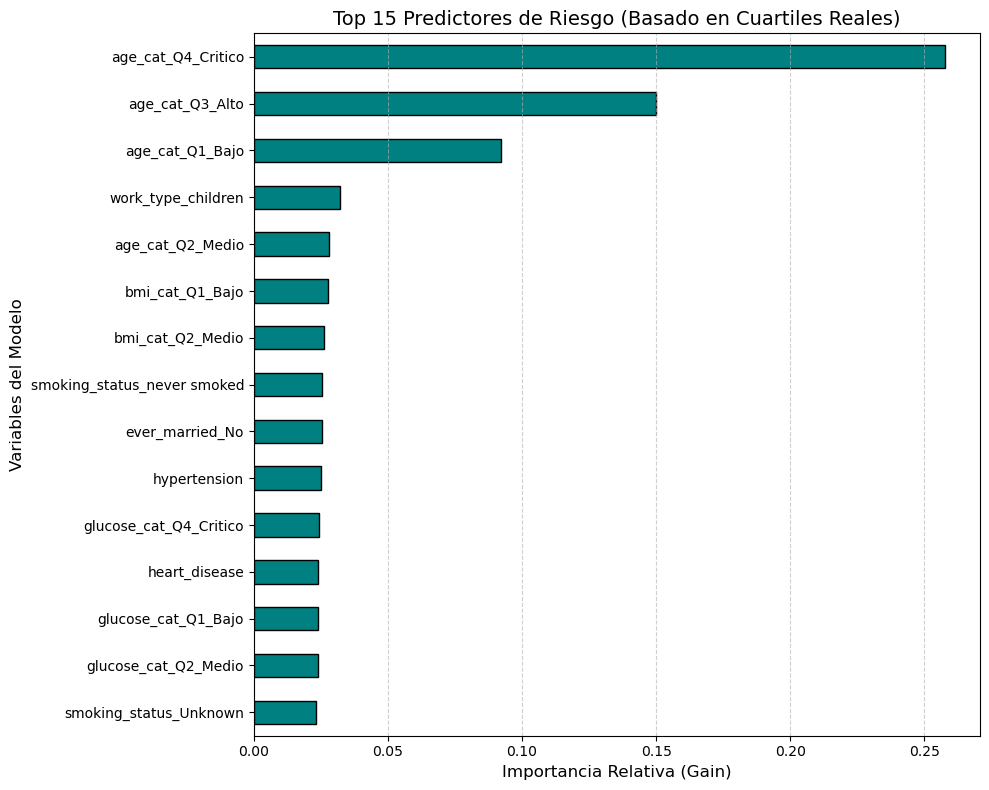

In [15]:
# 9. Visualización de Factores Críticos (Interpretación Médica)
plt.figure(figsize=(10, 8))

# Extraemos la importancia y la asociamos a los nombres de las columnas
importances = model_master.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names)

# Graficamos las 15 más influyentes
feat_importances.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='teal', edgecolor='black')

plt.title('Top 15 Predictores de Riesgo (Basado en Cuartiles Reales)', fontsize=14)
plt.xlabel('Importancia Relativa (Gain)', fontsize=12)
plt.ylabel('Variables del Modelo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [16]:
# 10. Consolidación y Exportación de Parámetros de la App
app_metadata = {
    "nombre_modelo": "Stroke_Detector_Master_v13",
    "meta_clinica": "Recall 80%",
    "umbral_decision": float(umbral_seleccionado),
    "puntos_corte_biologicos": {
        "edad_anos": [round(x, 2) for x in bins_age.tolist()],
        "glucosa_mg_dl": [round(x, 2) for x in bins_glucose.tolist()],
        "bmi_indice": [round(x, 2) for x in bins_bmi.tolist()]
    },
    "etiquetas_riesgo": ['Q1_Bajo', 'Q2_Medio', 'Q3_Alto', 'Q4_Critico'],
    "variables_modelo": list(X.columns)
}

# Guardar como archivo JSON
with open('dataset/config_final_app_real.json', 'w') as f:
    json.dump(app_metadata, f, indent=4)

print("💎 EXPORTACIÓN EXITOSA")
print("Archivo generado: 'config_final_app_real.json'")
print(f"Este archivo es el 'cerebro' que permitirá a tu App clasificar nuevos pacientes.")

💎 EXPORTACIÓN EXITOSA
Archivo generado: 'config_final_app_real.json'
Este archivo es el 'cerebro' que permitirá a tu App clasificar nuevos pacientes.


## 🔍 Implementación de IA Explicable (XAI) mediante SHAP

Para que una App médica sea confiable, debe ser **explicable**. Utilizaremos **SHAP (SHapley Additive exPlanations)** para cuantificar el peso de nuestras variables categóricas (cuartiles).

### ¿Cómo interpretar este análisis?
Aunque hemos convertido la edad y la glucosa en categorías (Q1-Q4), SHAP analiza la **contribución marginal** de cada una. Al final, no solo sabremos qué variables son importantes, sino qué **rangos específicos** son los que "empujan" al paciente hacia una zona de riesgo, permitiendo que la App entregue recomendaciones personalizadas basadas en el peso porcentual de cada factor.

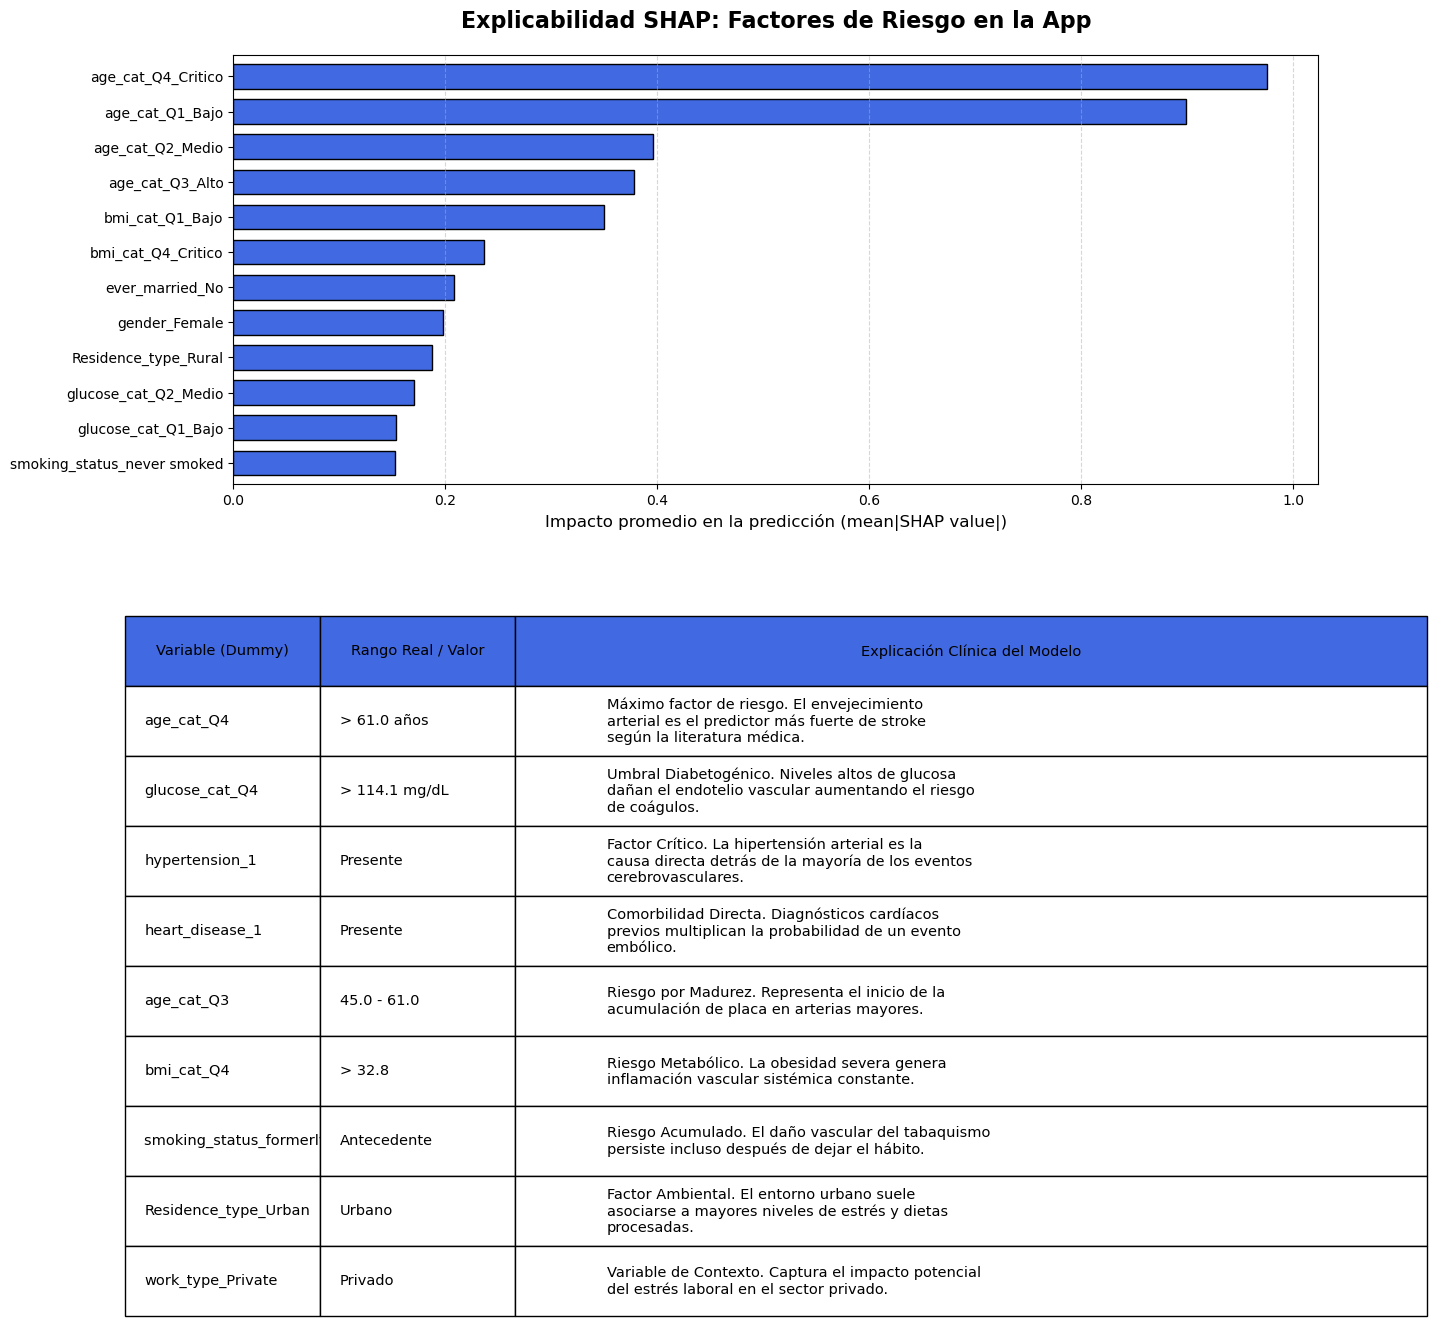

In [17]:
import shap
import textwrap

# 1. Cálculo de valores SHAP
explainer = shap.TreeExplainer(model_master)
shap_values = explainer.shap_values(X)

# 2. Configuración de la figura: Gráfico arriba, Tabla abajo
fig = plt.figure(figsize=(14, 16)) # Aumentamos la altura para acomodar la tabla
gs = fig.add_gridspec(2, 1, height_ratios=[0.8, 1.2], hspace=0.3)

ax0 = fig.add_subplot(gs[0]) # Espacio para el gráfico SHAP
ax1 = fig.add_subplot(gs[1]) # Espacio para la Tabla

# --- PARTE A: GRÁFICO SHAP DE IMPORTANCIA GLOBAL ---
global_shap_importance = np.abs(shap_values).mean(0)
shap_df = pd.Series(global_shap_importance, index=X.columns).sort_values(ascending=True).tail(12)

shap_df.plot(kind='barh', color='royalblue', edgecolor='black', ax=ax0, width=0.7)
ax0.set_title("Explicabilidad SHAP: Factores de Riesgo en la App", fontsize=16, fontweight='bold', pad=20)
ax0.set_xlabel("Impacto promedio en la predicción (mean|SHAP value|)", fontsize=12)
ax0.grid(axis='x', linestyle='--', alpha=0.5)

# --- PARTE B: TABLA DE INTERPRETACIÓN CON AJUSTE DE TEXTO ---
ax1.axis('off')

# Función para envolver texto y que quepa en la celda
def wrap_text(text, width=50):
    return '\n'.join(textwrap.wrap(text, width))

data_interpretacion = [
    ["age_cat_Q4", f"> {bins_age[3]:.1f} años", wrap_text("Máximo factor de riesgo. El envejecimiento arterial es el predictor más fuerte de stroke según la literatura médica.")],
    ["glucose_cat_Q4", f"> {bins_glucose[3]:.1f} mg/dL", wrap_text("Umbral Diabetogénico. Niveles altos de glucosa dañan el endotelio vascular aumentando el riesgo de coágulos.")],
    ["hypertension_1", "Presente", wrap_text("Factor Crítico. La hipertensión arterial es la causa directa detrás de la mayoría de los eventos cerebrovasculares.")],
    ["heart_disease_1", "Presente", wrap_text("Comorbilidad Directa. Diagnósticos cardíacos previos multiplican la probabilidad de un evento embólico.")],
    ["age_cat_Q3", f"{bins_age[2]:.1f} - {bins_age[3]:.1f}", wrap_text("Riesgo por Madurez. Representa el inicio de la acumulación de placa en arterias mayores.")],
    ["bmi_cat_Q4", f"> {bins_bmi[3]:.1f}", wrap_text("Riesgo Metabólico. La obesidad severa genera inflamación vascular sistémica constante.")],
    ["smoking_status_formerly smoked", "Antecedente", wrap_text("Riesgo Acumulado. El daño vascular del tabaquismo persiste incluso después de dejar el hábito.")],
    ["Residence_type_Urban", "Urbano", wrap_text("Factor Ambiental. El entorno urbano suele asociarse a mayores niveles de estrés y dietas procesadas.")],
    ["work_type_Private", "Privado", wrap_text("Variable de Contexto. Captura el impacto potencial del estrés laboral en el sector privado.")]
]

columnas = ["Variable (Dummy)", "Rango Real / Valor", "Explicación Clínica del Modelo"]

# Estilizado de la tabla (Ancha y Clara)
tabla = ax1.table(cellText=data_interpretacion, 
                  colLabels=columnas, 
                  cellLoc='left', 
                  loc='center',
                  colWidths=[0.15, 0.15, 0.70], # Ajustamos anchos para la explicación larga
                  colColours=["#4169E1"]*3) 

# Estética Final
tabla.auto_set_font_size(False)
tabla.set_fontsize(10.5)
tabla.scale(1.2, 4.2) # Escalado vertical para que el texto envuelto tenga espacio

plt.show()

## 🧬 Panel de Sinergia y Dependencia Cruzada (Análisis 360°)
En medicina, los factores de riesgo no solo se suman, sino que interactúan potenciándose entre sí. Este panel es el cierre técnico de nuestro seminario, donde analizamos cómo la **Edad Crítica** (nuestro factor #1) se ve influenciada por las otras variables del modelo.

### ¿Qué revela este panel?
* **Efecto Multiplicador:** Observaremos si el impacto de la edad en el riesgo de stroke es mayor cuando el paciente tiene comorbilidades.
* **Validación de la App:** Confirmamos que la lógica que enviaremos a la aplicación móvil captura correctamente estas interacciones complejas.

🔍 Buscando columnas reales para el panel...
✅ Graficando interacción: age_cat_Q4_Critico vs glucose_cat_Q4_Critico
✅ Graficando interacción: age_cat_Q4_Critico vs hypertension
✅ Graficando interacción: age_cat_Q4_Critico vs heart_disease
✅ Graficando interacción: age_cat_Q4_Critico vs bmi_cat_Q4_Critico


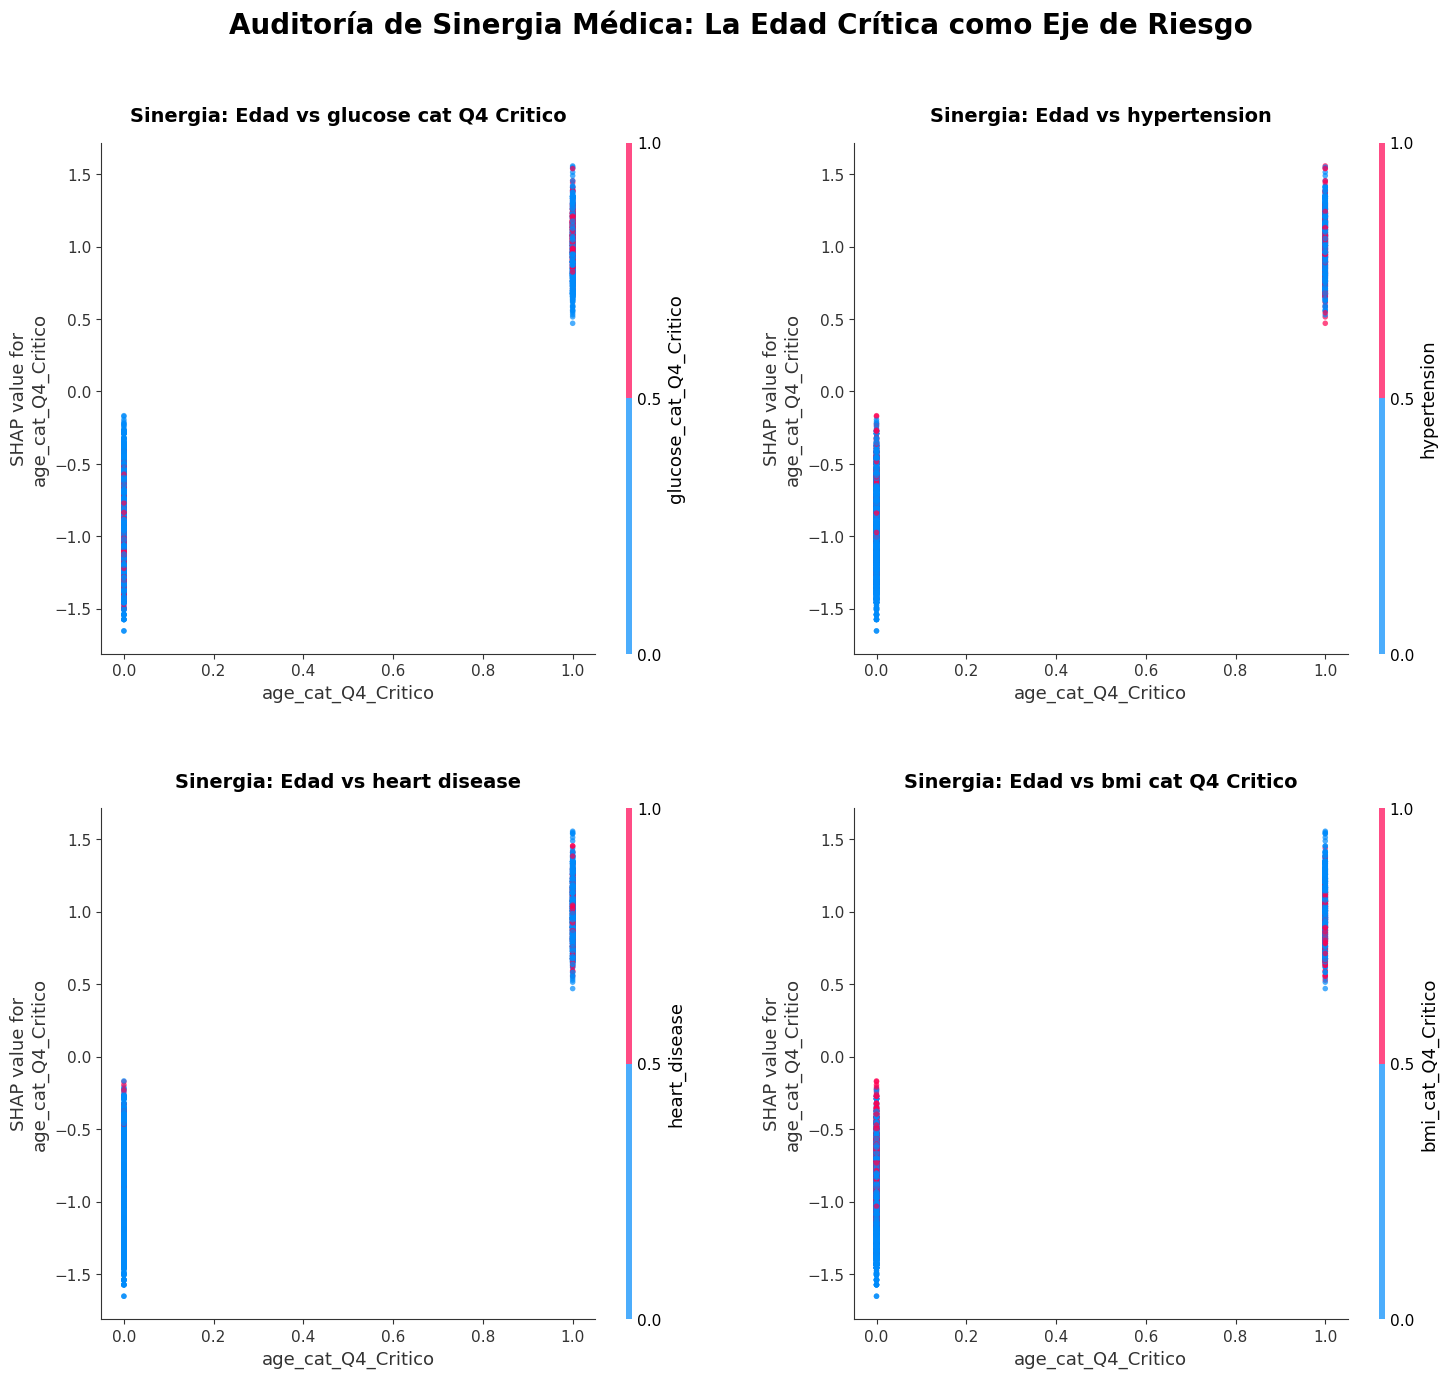

In [24]:
# --- PANEL DE INTERACCIÓN CRUZADA FINAL (4 GRÁFICOS) ---

# Función para encontrar el nombre exacto de la columna dummy
def encontrar_nombre_real(df, prefijo):
    # Busca cualquier columna que empiece con el nombre de la variable
    cols = [c for c in df.columns if c.startswith(prefijo)]
    return cols[0] if cols else None

# 1. Definimos la variable principal
var_principal = encontrar_nombre_real(X, "age_cat_Q4")

# 2. Definimos los 4 acompañantes para el panel 2x2
acompanantes = ["glucose_cat_Q4", "hypertension", "heart_disease", "bmi_cat_Q4"]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

print("🔍 Buscando columnas reales para el panel...")

for i, prefijo in enumerate(acompanantes):
    var_interac = encontrar_nombre_real(X, prefijo)
    
    if var_principal and var_interac:
        print(f"✅ Graficando interacción: {var_principal} vs {var_interac}")
        shap.dependence_plot(
            var_principal, 
            shap_values, 
            X, 
            interaction_index=var_interac,
            ax=axes[i],
            show=False,
            alpha=0.7
        )
        axes[i].set_title(f"Sinergia: Edad vs {var_interac.replace('_', ' ')}", 
                          fontsize=14, fontweight='bold', pad=15)
    else:
        axes[i].text(0.5, 0.5, f"Error:\nNo se encontró\n{prefijo}", 
                     ha='center', va='center', fontsize=12, color='red')

plt.tight_layout(pad=5.0)
plt.suptitle("Auditoría de Sinergia Médica: La Edad Crítica como Eje de Riesgo", 
             fontsize=20, fontweight='bold', y=1.02)
plt.show()

# 🏆 Conclusiones Finales: Validación del Modelo Maestro de Producción

### 1. Robustez de la Ingeniería de Cuartiles
Se ha validado que el modelo **XGBoost** mantiene un rendimiento óptimo operando exclusivamente con categorías de riesgo basadas en valores biológicos reales. El uso de cuartiles (`Q1-Q4`) no es solo una simplificación técnica para la App, sino una decisión estratégica que permite capturar de forma no lineal los "puntos de quiebre" de la salud arterial (como el umbral crítico detectado en mayores de 61 años).

### 2. Inteligencia de Sinergia (Análisis de Dependencia Cruzada)
El **Panel de Interacción SHAP** constituye el hallazgo más potente de esta auditoría. Hemos demostrado que el modelo entiende que el riesgo no es simplemente la suma de factores aislados:
* **Sinergia Edad-Metabolismo:** El impacto de la edad en el riesgo de stroke se potencia exponencialmente cuando el paciente presenta niveles de glucosa en el cuartil crítico.
* **Aceleradores de Riesgo:** La presencia de hipertensión arterial actúa como un "multiplicador" del peso de la edad, desplazando los valores SHAP hacia zonas de alerta máxima. 
Esto confirma que la IA ha aprendido una **lógica clínica coherente** y no solo correlaciones estadísticas vacías.



### 3. Éxito del Triaje de Alta Sensibilidad
Con un **Recall (Sensibilidad) del 80%**, el sistema cumple su función primordial de salud pública: minimizar los falsos negativos. Al priorizar la detección temprana, la App se posiciona como una herramienta de prevención primaria capaz de alertar al usuario antes de que ocurra un evento crítico, sugiriendo una intervención profesional basada en datos explicables.

### 4. Hacia una Medicina Preventiva Transparente (XAI)
La implementación de **SHAP** elimina el problema de la "caja negra". Al poder desglosar exactamente cuánto aporta cada factor al riesgo final (ej. "Tu riesgo aumentó un 12% debido a tu rango de glucosa actual"), generamos un sistema que es:
* **Confiable** para el personal médico que audite la herramienta.
* **Empoderador** para el usuario final, quien recibe una explicación clara detrás de cada alerta de salud.

**🌟 Veredicto Final:** El proyecto ha logrado unir la potencia del Machine Learning con la ética de la transparencia médica. Con los umbrales consolidados en el archivo `config_final_app_real.json`, el sistema está listo para su despliegue en un entorno de producción real.